In [1]:
import gc
import torch

gc.collect()

torch.cuda.empty_cache()

In [2]:
# %pip install sam2

In [3]:
# !git clone https://github.com/facebookresearch/sam2

In [4]:
%cd sam2/

d:\tracker\video_tracker\sam2


In [ ]:
import cv2
import os

# Make sure output folder exists
output_dir = "../video frame"

if os.path.isdir(output_dir):
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        
        # Check if it is a file (not a subdirectory)
        if os.path.isfile(file_path):
            os.remove(file_path)  # Remove the file
            print(f"Deleted file: {filename}")

os.makedirs(output_dir, exist_ok=True)

# Open video
vidcap = cv2.VideoCapture('../Feel_special - Trim.mp4')

success, image = vidcap.read()
count = 0

while success:
    # Build output file path
    filename = os.path.join(output_dir, f"{count}.jpg")
    # Save frame
    cv2.imwrite(filename, image)
    print(f"Saved {filename}")
    # Read next frame
    success, image = vidcap.read()
    count += 1

print("Done! Extracted", count, "frames.")


Deleted file: 0.jpg
Deleted file: 1.jpg
Deleted file: 10.jpg
Deleted file: 100.jpg
Deleted file: 101.jpg
Deleted file: 102.jpg
Deleted file: 103.jpg
Deleted file: 104.jpg
Deleted file: 105.jpg
Deleted file: 106.jpg
Deleted file: 107.jpg
Deleted file: 108.jpg
Deleted file: 109.jpg
Deleted file: 11.jpg
Deleted file: 110.jpg
Deleted file: 111.jpg
Deleted file: 112.jpg
Deleted file: 113.jpg
Deleted file: 114.jpg
Deleted file: 115.jpg
Deleted file: 116.jpg
Deleted file: 117.jpg
Deleted file: 118.jpg
Deleted file: 119.jpg
Deleted file: 12.jpg
Deleted file: 120.jpg
Deleted file: 121.jpg
Deleted file: 122.jpg
Deleted file: 123.jpg
Deleted file: 124.jpg
Deleted file: 125.jpg
Deleted file: 126.jpg
Deleted file: 127.jpg
Deleted file: 128.jpg
Deleted file: 129.jpg
Deleted file: 13.jpg
Deleted file: 130.jpg
Deleted file: 131.jpg
Deleted file: 132.jpg
Deleted file: 133.jpg
Deleted file: 134.jpg
Deleted file: 135.jpg
Deleted file: 136.jpg
Deleted file: 137.jpg
Deleted file: 138.jpg
Deleted file: 139.

In [6]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.6.0+cu118
Torchvision version: 0.21.0+cu118
CUDA is available: True


In [7]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [9]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [10]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

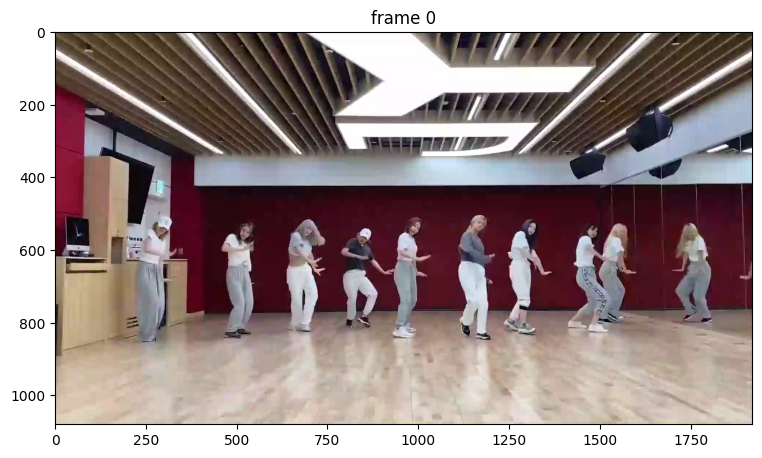

In [11]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "../video frame"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [12]:
inference_state = predictor.init_state(video_path=video_dir, offload_video_to_cpu=True)

frame loading (JPEG): 100%|██████████| 317/317 [00:09<00:00, 34.26it/s]


In [13]:
predictor.reset_state(inference_state)

d:\tracker\video_tracker\sam2\sam2\sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (d:\tracker\video_tracker\sam2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


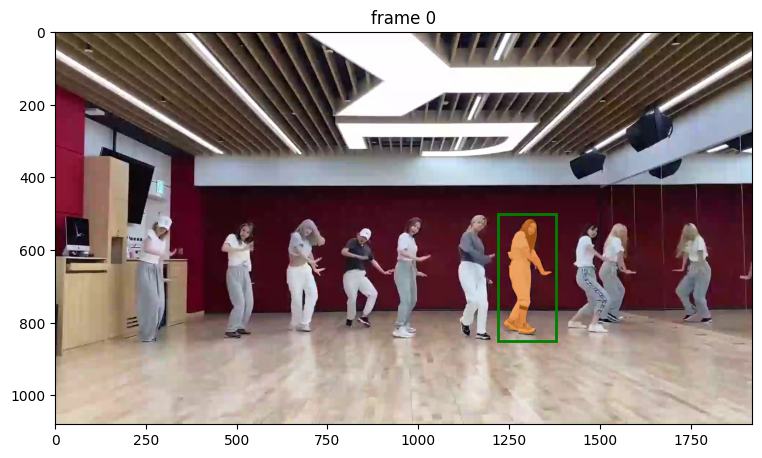

In [14]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[1290, 600]], dtype=np.float32)
# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = np.array([1220, 500, 1380, 850], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [15]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# # render the segmentation results every few frames
# vis_frame_stride = 30
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

propagate in video: 100%|██████████| 317/317 [01:16<00:00,  4.15it/s]


In [16]:
# REFINE THE SEGMENT 

# ann_frame_idx = 150  # further refine some details on this frame
# ann_obj_id = 1  # give a unique id to the object we interact with (it can be any integers)

# # show the segment before further refinement
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx} -- before refinement")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# # Let's add a negative click on this frame at (x, y) = (82, 415) to refine the segment
# points = np.array([[82, 410]], dtype=np.float32)
# # for labels, `1` means positive click and `0` means negative click
# labels = np.array([0], np.int32)
# _, _, out_mask_logits = predictor.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )

# # show the segment after the further refinement
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx} -- after refinement")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_points(points, labels, plt.gca())
# show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

In [22]:
output_crop_dir = "../video_crops"
if os.path.isdir(output_crop_dir):
    for filename in os.listdir(output_crop_dir):
        file_path = os.path.join(output_crop_dir, filename)
        
        # Check if it is a file (not a subdirectory)
        if os.path.isfile(file_path):
            os.remove(file_path)  # Remove the file
            print(f"Deleted file: {filename}")

os.makedirs(output_crop_dir, exist_ok=True)

for out_frame_idx in range(len(frame_names)):
    frame_path = os.path.join(video_dir, frame_names[out_frame_idx])
    frame = np.array(Image.open(frame_path))

    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        mask_2d = np.squeeze(out_mask)
        ys, xs = np.where(mask_2d > 0)

        if ys.size == 0 or xs.size == 0:
            continue
        
        extend_val = 40

        x_min, x_max = xs.min() - extend_val, xs.max() + extend_val
        y_min, y_max = ys.min() - extend_val, ys.max() + extend_val

        crop = frame[y_min:y_max, x_min:x_max]

        save_name = f"frame{out_frame_idx:05d}_obj{out_obj_id}.jpg"
        save_path = os.path.join(output_crop_dir, save_name)

        Image.fromarray(crop).save(save_path)
        print(f"Saved: {save_path}")

Deleted file: frame00000_obj1.jpg
Deleted file: frame00001_obj1.jpg
Deleted file: frame00002_obj1.jpg
Deleted file: frame00003_obj1.jpg
Deleted file: frame00004_obj1.jpg
Deleted file: frame00005_obj1.jpg
Deleted file: frame00006_obj1.jpg
Deleted file: frame00007_obj1.jpg
Deleted file: frame00008_obj1.jpg
Deleted file: frame00009_obj1.jpg
Deleted file: frame00010_obj1.jpg
Deleted file: frame00011_obj1.jpg
Deleted file: frame00012_obj1.jpg
Deleted file: frame00013_obj1.jpg
Deleted file: frame00014_obj1.jpg
Deleted file: frame00015_obj1.jpg
Deleted file: frame00016_obj1.jpg
Deleted file: frame00017_obj1.jpg
Deleted file: frame00018_obj1.jpg
Deleted file: frame00019_obj1.jpg
Deleted file: frame00020_obj1.jpg
Deleted file: frame00021_obj1.jpg
Deleted file: frame00022_obj1.jpg
Deleted file: frame00023_obj1.jpg
Deleted file: frame00024_obj1.jpg
Deleted file: frame00025_obj1.jpg
Deleted file: frame00026_obj1.jpg
Deleted file: frame00027_obj1.jpg
Deleted file: frame00028_obj1.jpg
Deleted file: 